In [1]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, diags, eye, block_diag, bmat
from scipy.sparse.linalg import norm


from utils import topk_idx, sample_unseen
try:
    from ipypb import track
except ImportError:
    from tqdm.auto import tqdm as track
    
from polara.datasets.movielens import get_movielens_data
from dataprep import split_holdout, sample_unseen_interactions
from utils import topk_idx, sample_unseen

In [2]:
split_seed, rand_seed, holdout_seed = 0, 99, 42

# Data

In [3]:
#Load row Data file
DATA_NAME = 'ml-1m'
DATA_FILE = '../{}.zip'.format(DATA_NAME)

ml_data = get_movielens_data(local_file=DATA_FILE, get_genres=False)

## Use sparse format

In [4]:
# encode users and items to [0, N] interval with no missing indices
useridx, all_users = pd.factorize(ml_data.userid)
itemidx, all_items = pd.factorize(ml_data.movieid)

In [5]:
all_ratings = csr_matrix( # for efficient storage and some computations
    (
        ml_data.rating.values,
        (useridx, itemidx)
    )
)
all_ratings

<6040x3706 sparse matrix of type '<class 'numpy.int64'>'
	with 1000209 stored elements in Compressed Sparse Row format>

In [6]:
print(
    "Initial Mtx:\nUsers: {};\nItems: {};\nNNZ entries: {};\nDensity: {:%}"
    .format(
        *all_ratings.shape,
        all_ratings.nnz,
        all_ratings.nnz / np.prod(all_ratings.shape)
    )
)

Initial Mtx:
Users: 6040;
Items: 3706;
NNZ entries: 1000209;
Density: 4.468363%


## Train-test split

In [7]:
def test_split(matrix, seed=None):
    '''
    Uses CSR format to efficiently access non-zero elements.
    Can be easily wrapped by numba jit with minor changes.
    '''
    test_items = []
    indptr = matrix.indptr
    indices = matrix.indices
    data = matrix.data
    np.random.seed(seed) # control randomization
    for i in range(len(indptr)-1): # for every user i
        head = indptr[i]
        tail = indptr[i+1]
        vals = data[head:tail] # user ratings
        pos_max, = np.where(vals == vals.max())
        top_items = indices[head + pos_max] # top-rated items for user i
        test_items.append(np.random.choice(top_items)) # sample of top-rated
    return np.array(test_items)

In [8]:
test_items = test_split(all_ratings, seed=split_seed)

In [9]:
train_matrix = all_ratings.copy() # avoid mutating original data
train_matrix[np.arange(len(test_items)), test_items] = 0 # exclude test items
train_matrix.eliminate_zeros()
train_matrix = (train_matrix > 0).astype('f8') # make data implicit

In [10]:
train_matrix

<6040x3706 sparse matrix of type '<class 'numpy.float64'>'
	with 994169 stored elements in Compressed Sparse Row format>

In [11]:
print(
    "Train Mtx:\nUsers: {};\nItems: {};\nNNZ entries: {};\nDensity: {:%}"
    .format(
        *train_matrix.shape,
        train_matrix.nnz,
        train_matrix.nnz / np.prod(train_matrix.shape)
    )
)

Train Mtx:
Users: 6040;
Items: 3706;
NNZ entries: 994169;
Density: 4.441379%


In [12]:
holdout_unseen = sample_unseen_interactions(
    ml_data,
    all_items.to_numpy(),
    itemid='movieid',
    seed=holdout_seed)
holdout_unseen.head()

userid
1    [2906, 3011, 2437, 1116, 3225, 3354, 440, 1572...
2    [333, 3090, 3639, 3376, 1150, 3765, 2110, 2849...
3    [2927, 2208, 1305, 3126, 3947, 1771, 1711, 345...
4    [704, 992, 864, 2196, 1709, 1055, 2939, 2751, ...
5    [722, 1236, 2897, 804, 2751, 791, 3194, 473, 5...
Name: movieid, dtype: object

## Reindex datasets

In [13]:
unseen_samples = np.array([
    [all_items.get_loc(i) for i in x]
    for x in holdout_unseen.loc[all_users]
])

holdout_items = (
    pd.Series(test_items, index=all_users, dtype='int64')
    .values
)                 

# Model

## SLIM

```python
from SLIM import SLIM, SLIMatrix
#Parameters on NN:
n_items = train_matrix.shape[1]
C = int(n_items * 0.1)
 #Train Matrix W:
trainmat = SLIMatrix(train_matrix)
params = {'algo':'cd',
          'nthreads': 4,
          'l1r': 10,
          'l2r': 10,
          'nnbrs': C
         }
model = SLIM()
model.train(params, trainmat)
#Got Matrix W:
WSlim = model.to_csr()
np.savez_compressed(
    'W_model_SLIM_ML1M',
    indices = WSlim.indices,
    indptr = WSlim.indptr,
    data = WSlim.data,
    item_index = all_items
)
```

In [14]:
WSlim_data = np.load('W_model_SLIM_ML1M.npz')
WSlim = csr_matrix(
    (WSlim_data['data'], WSlim_data['indices'], WSlim_data['indptr']),
    shape = (len(WSlim_data['item_index']),)*2
)
np.testing.assert_array_equal(all_items, WSlim_data['item_index'])

WSlim

<3706x3706 sparse matrix of type '<class 'numpy.float32'>'
	with 113242 stored elements in Compressed Sparse Row format>

In [15]:
#Density of distance matrix W, diagonal and other elements
print(f"Density of W: {WSlim.nnz / np.prod(WSlim.shape):%}")
print(f"Number of elements less than 0 in W: {(WSlim.data<0).sum()}")
print(f"Maximal diagonal element of the W:   {WSlim.diagonal().max()}")

Density of W: 0.824511%
Number of elements less than 0 in W: 0
Maximal diagonal element of the W:   0.0


## RecWalk

In [16]:
#Make P matrix that our final recommendation model
def rec_walk_model(item_model, rating_matrix, alpha=0.005):
    inter_item = item_model / norm(item_model, np.inf)
    adjustment = 1 - inter_item.sum(axis=1).A.squeeze() # stochasticity adjustment
    inter_item += diags(adjustment, shape=item_model.shape, format='csr')

    transition = block_diag( # M matrix
        (eye(rating_matrix.shape[0], format='csr'), inter_item),
        format = 'csr',
        dtype = 'float64'
    )
    walk_model = bmat( # H matrix
        [[None, rating_matrix], [rating_matrix.T, None]],
        format = 'csr',
        dtype = 'float64'
    )
    k = np.reciprocal(walk_model.sum(axis=1).A.squeeze())
    walk_model = diags(k, format='csr').dot(walk_model)
    return alpha * walk_model + (1-alpha) * transition

In [17]:
#RecWalk P matrix with W SLIM based:
transition_matrix = rec_walk_model(WSlim, train_matrix)

In [18]:
print(f"Density of P: {transition_matrix.nnz/np.prod(transition_matrix.shape):%}")

Density of P: 2.222811%


# Evaluation

In [19]:
def evaluate(scores, holdout_items, holdout_unseen, topk=10):
    rows = np.arange(len(holdout_items))
    holdout_scores = scores[rows, holdout_items]
    random_scores = scores[
        np.broadcast_to(rows[:, None], holdout_unseen.shape),
        holdout_unseen
    ]
    
    test_scores = np.concatenate((holdout_scores[:, None], random_scores), axis=1)
    top_recs = np.apply_along_axis(topk_idx, 1, test_scores, topk)        
    _, rec_pos = np.where(top_recs == 0) # holdout has index 0 by construction
    
    hr = len(rec_pos) / len(holdout_items)
    arhr = np.reciprocal(rec_pos + 1.).sum() / len(holdout_items)
    return hr, arhr

In [20]:
# Make a few more steps to future to capture intersactions between items:
K = 20

n_users = train_matrix.shape[0]
k_step_matrix = transition_matrix[:n_users, :].toarray()
transition_matrix = transition_matrix.tocsc()

metrics = []
for k in track(range(K)): 
    k_step_matrix = transition_matrix.T.dot(k_step_matrix.T).T
    prediction_matrix = k_step_matrix[:, n_users:]
    metrics.append(
        evaluate(prediction_matrix, holdout_items, unseen_samples)
    )

## Plot results

In [21]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [22]:
hr, arhr = zip(*metrics)

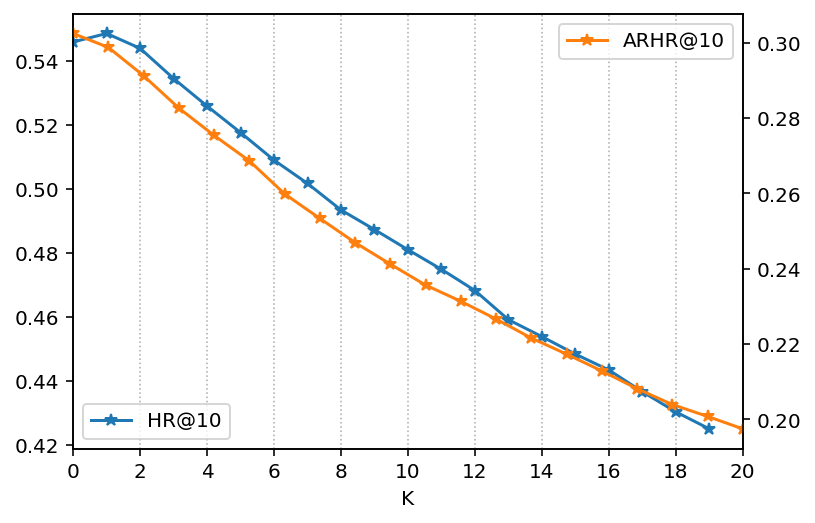

In [23]:
ax1 = pd.Series(hr).plot(linestyle='-', marker='*', label='HR@10')
ax2 = pd.Series(arhr).plot(secondary_y=True, linestyle='-', marker='*', label='ARHR@10')

ax1.set_xlabel('K')
ax1.xaxis.grid(True, linestyle=':')
ax1.set_xticks(range(0, 22, 2))
ax1.legend(loc=3)

ax2.legend(loc=0);